In [1]:
import numpy as np
import sklearn
import torch
import os
import matplotlib.pyplot as plt


In [2]:
if not os.path.exists('tree_species_classifier_data.npz'):
  !wget -O tree_species_classifier_data.npz "https://www.dropbox.com/scl/fi/b7mw23k3ifaeui9m8nnn3/tree_species_classifier_data.npz?rlkey=bgxp37c1t04i7q35waf3slc26&dl=1"

In [3]:
data = np.load('tree_species_classifier_data.npz')
train_features = data['train_features']
train_labels = data['train_labels']
test_features = data['test_features']
test_labels = data['test_labels']

# 1. Inspecting Data

In [4]:
# Shapes of matricies
print('Shapes of Matricies')

## Training matricies
print(f'Train Features shape: {train_features.shape}')
print(f'Train Labels shape: {train_labels.shape}\n')

## Test matricies
print(f'Test Features shape: {test_features.shape}')
print(f'Test Labels shape: {test_labels.shape}')

Shapes of Matricies
Train Features shape: (15707, 426)
Train Labels shape: (15707,)

Test Features shape: (1554, 426)
Test Labels shape: (1554,)


In [5]:
# Types of matricies
print('Types of Matricies')

## Training matricies
print(f'Train Features type: {train_features.dtype}')
print(f'Train Labels type: {train_labels.dtype}\n')

## Test matricies
print(f'Test Features type: {test_features.dtype}')
print(f'Test Labels type: {test_labels.dtype}')

Types of Matricies
Train Features type: int16
Train Labels type: uint8

Test Features type: int16
Test Labels type: uint8


In [6]:
# Feature Ranges
print('Feature Ranges')

print(f"Train Min: {train_features.min()}, Train Max: {train_features.max()}")
print(f"Test Min: {test_features.min()}, Test Max: {test_features.max()}")

Feature Ranges
Train Min: 0, Train Max: 14998
Test Min: 0, Test Max: 6908


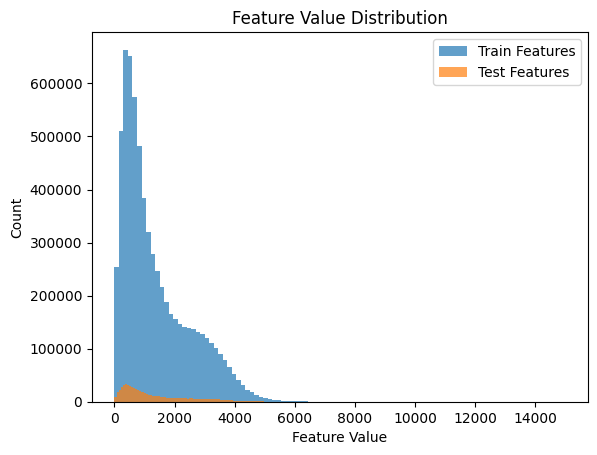

In [7]:
plt.hist(train_features.flatten(), bins=100, alpha=.7, label='Train Features')
plt.hist(test_features.flatten(), bins=100, alpha=.7, label='Test Features')
plt.title('Feature Value Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Count')
plt.legend()

In [8]:
# Train Distribution
print("Train Distribution")

train_unique, train_counts = np.unique(train_labels, return_counts=True)
print(f'Train Labels: {dict(zip(train_unique, train_counts))}')

Train Distribution
Train Labels: {0: 2519, 1: 821, 2: 1575, 3: 3980, 4: 2640, 5: 88, 6: 852, 7: 3232}


In [9]:
# Test Distribution
print("Test Distribution")

test_unique, test_counts = np.unique(test_labels, return_counts=True)
print(f'Test Labels: {dict(zip(test_unique, test_counts))}')

Test Distribution
Test Labels: {0: 389, 1: 30, 2: 278, 3: 404, 4: 100, 5: 22, 6: 43, 7: 288}


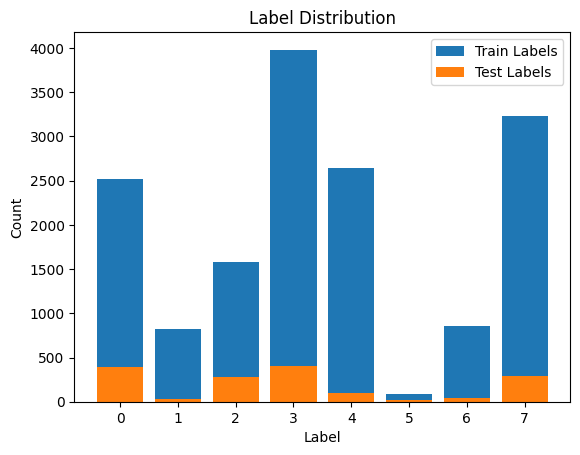

In [10]:
plt.bar(train_unique, train_counts, label='Train Labels')
plt.bar(test_unique, test_counts, label='Test Labels')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend()

# 2. Pre-process Data (PCA)

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=32, whiten=True)

train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

print(f'Train Features shape: {train_features_pca.shape}')
print(f'Test Features shape: {test_features_pca.shape}')

Train Features shape: (15707, 32)
Test Features shape: (1554, 32)


# 3. Create Sci-kit learn Classifiers

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [14]:
linear_scikit = LogisticRegression()
linear_scikit.fit(train_features_pca, train_labels)
linear_scikit_preds = linear_scikit.predict(test_features_pca)
linear_scikit_acc = accuracy_score(test_labels, linear_scikit_preds)
print(f"Linear Classifier Test Accuracy: {linear_scikit_acc}")

Linear Classifier Test Accuracy: 0.833976833976834


In [15]:
nn_scikit = MLPClassifier(hidden_layer_sizes=(100, 100, 100))
nn_scikit.fit(train_features_pca, train_labels)
nn_scikit_preds = nn_scikit.predict(test_features_pca)
nn_scikit_acc = accuracy_score(test_labels, nn_scikit_preds)
print(f"Neural Network Classifier Test Accuracy: {nn_scikit_acc}")

Neural Network Classifier Test Accuracy: 0.8262548262548263


# 4. Create Torch Models

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [17]:
def preprocess_data():
    train_data = TensorDataset(
        torch.tensor(train_features_pca, dtype=torch.float32),
        torch.tensor(train_labels, dtype=torch.long)
    )

    test_data = TensorDataset(
        torch.tensor(test_features_pca, dtype=torch.float32),
        torch.tensor(test_labels, dtype=torch.long)
    )
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader, test_loader


In [18]:
def accuracy(model, data_loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for features, labels in data_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [19]:
def train_model(model, train_loader, test_loader, epochs=100, lr=1e-2, weight_decay=1e-3):
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = ce(outputs, labels)
            loss.backward()
            optimizer.step()

        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_acc}, Test Accuracy: {test_acc}')

In [20]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [22]:
train_loader, test_loader = preprocess_data()

linear_model = LinearModel(32, 8)
train_model(linear_model, train_loader, test_loader)


Epoch 1/100, Train Accuracy: 0.7609982810212007, Test Accuracy: 0.7625482625482626
Epoch 2/100, Train Accuracy: 0.7936588782071687, Test Accuracy: 0.7972972972972973
Epoch 3/100, Train Accuracy: 0.806646718023811, Test Accuracy: 0.8075933075933076
Epoch 4/100, Train Accuracy: 0.8155599414273891, Test Accuracy: 0.8063063063063063
Epoch 5/100, Train Accuracy: 0.8221175272171644, Test Accuracy: 0.8082368082368082
Epoch 6/100, Train Accuracy: 0.8260011459858662, Test Accuracy: 0.8088803088803089
Epoch 7/100, Train Accuracy: 0.8301394282803846, Test Accuracy: 0.8114543114543115
Epoch 8/100, Train Accuracy: 0.8316037435538295, Test Accuracy: 0.8108108108108109
Epoch 9/100, Train Accuracy: 0.833322722353091, Test Accuracy: 0.8133848133848134
Epoch 10/100, Train Accuracy: 0.8340230470490864, Test Accuracy: 0.8153153153153153
Epoch 11/100, Train Accuracy: 0.8344050423378112, Test Accuracy: 0.8178893178893178
Epoch 12/100, Train Accuracy: 0.8357420258483479, Test Accuracy: 0.8172458172458172
Epo

In [23]:

nn_model = NeuralNetwork(32, 8)
train_model(nn_model, train_loader, test_loader)

Epoch 1/100, Train Accuracy: 0.43381931622843317, Test Accuracy: 0.4202059202059202
Epoch 2/100, Train Accuracy: 0.6916024702362005, Test Accuracy: 0.7014157014157014
Epoch 3/100, Train Accuracy: 0.7717578149869485, Test Accuracy: 0.7953667953667953
Epoch 4/100, Train Accuracy: 0.8049277392245495, Test Accuracy: 0.8166023166023166
Epoch 5/100, Train Accuracy: 0.8256191506971414, Test Accuracy: 0.8166023166023166
Epoch 6/100, Train Accuracy: 0.841726618705036, Test Accuracy: 0.8326898326898327
Epoch 7/100, Train Accuracy: 0.8500031832940728, Test Accuracy: 0.8384813384813384
Epoch 8/100, Train Accuracy: 0.8565607690838479, Test Accuracy: 0.8410553410553411
Epoch 9/100, Train Accuracy: 0.8606353854969122, Test Accuracy: 0.8397683397683398
Epoch 10/100, Train Accuracy: 0.8637550136881645, Test Accuracy: 0.8455598455598455
Epoch 11/100, Train Accuracy: 0.8673203030495957, Test Accuracy: 0.8455598455598455
Epoch 12/100, Train Accuracy: 0.8697396065448526, Test Accuracy: 0.8487773487773488
E